# Introduction

The objective of this project is to apply machine learning on a Kaggle dataset called Titanic : https://www.kaggle.com/c/titanic

This dataset is split into 2 csv files: 

    1. train.csv
    2. test.csv

The idea is to predict who died on test.csv file based on train.csv file.

In [1]:
# Import libraries for data exploration
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils import resample 

# Import data

In [2]:
# Create datasets with our 2 csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dfs = [test,train]

for df in dfs:
    print(df.shape)

(418, 11)
(891, 12)


# Data Exploration

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Creating features

In [5]:
for df in dfs:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

train.Title.unique()

array([&#39;Mr&#39;, &#39;Mrs&#39;, &#39;Miss&#39;, &#39;Master&#39;, &#39;Don&#39;, &#39;Rev&#39;, &#39;Dr&#39;, &#39;Mme&#39;, &#39;Ms&#39;,
       &#39;Major&#39;, &#39;Lady&#39;, &#39;Sir&#39;, &#39;Mlle&#39;, &#39;Col&#39;, &#39;Capt&#39;, &#39;Countess&#39;,
       &#39;Jonkheer&#39;], dtype=object)

In [6]:
for df in dfs:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [7]:
for df in dfs:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [8]:
for df in dfs:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


# Missing Data

In [9]:
train.info()
test.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    object 
 13  FamilySize   891 non-null    int64  
 14  IsAlone      891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB
&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 418 entries, 0 to 417
Data columns (tot

In [10]:
# Dealing with Missing Data
for df in dfs:
    df['Age'].fillna(df['Age'].median(), inplace = True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    df['Fare'].fillna(df['Fare'].median(), inplace = True)
    df.drop(columns = ['Cabin','FamilySize','SibSp','Parch','Ticket','Name'],inplace = True)

train.dropna(inplace = True)
test.fillna(0,inplace = True)

len(train)

891

We notice that we have missing data for the following columns:

    Age
    Cabin
    Embarked

In [11]:
# Some values could be wrong as well, let's check some columns
for i in train.columns:
    if i in ['Survived','Pclass','Sex','SibSp','Parch','Embarked']:
        print(train[i].unique())

[0 1]
[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


# Format Data: X and y

In [12]:
X = train.drop(columns = ["Survived","PassengerId"])
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,3,male,22.0,7.2500,S,Mr,0
1,1,female,38.0,71.2833,C,Mrs,0
2,3,female,26.0,7.9250,S,Miss,1
3,1,female,35.0,53.1000,S,Mrs,0
4,3,male,35.0,8.0500,S,Mr,1


In [13]:
Y = train["Survived"]
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Format the Data: Scaling

In [14]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
Fare        float64
Embarked     object
Title        object
IsAlone       int64
dtype: object

In [15]:
for i in X.columns:
    if i in ['Pclass','Sex','SibSp','Parch','Embarked']:
        print(X[i].unique())

[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


In [16]:
X =     pd.get_dummies(X,   columns=['Sex','Embarked','Title'])
test =  pd.get_dummies(test,columns=['Sex','Embarked','Title'])
X.head()

,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,7.2500,0,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,0,1,0,1,0,0,0,0,0,1,0
2,3,26.0,7.9250,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,53.1000,0,1,0,0,0,1,0,0,0,1,0
4,3,35.0,8.0500,1,0,1,0,0,1,0,0,1,0,0


In [17]:
test.head()

,PassengerId,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,34.5,7.8292,1,0,1,0,1,0,0,0,1,0,0
1,893,3,47.0,7.0000,0,1,0,0,0,1,0,0,0,1,0
2,894,2,62.0,9.6875,1,0,1,0,1,0,0,0,1,0,0
3,895,3,27.0,8.6625,1,0,1,0,0,1,0,0,1,0,0
4,896,3,22.0,12.2875,0,1,0,0,0,1,0,0,0,1,0


# Support Vector Machine

In [18]:
X.head()

,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,7.2500,0,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,0,1,0,1,0,0,0,0,0,1,0
2,3,26.0,7.9250,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,53.1000,0,1,0,0,0,1,0,0,0,1,0
4,3,35.0,8.0500,1,0,1,0,0,1,0,0,1,0,0


In [19]:
X.describe()

,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.361582,32.204208,0.602694,0.352413,0.647587,0.188552,0.086420,0.725028,0.044893,0.207632,0.580247,0.141414,0.025814
std,0.836071,13.019697,49.693429,0.489615,0.477990,0.477990,0.391372,0.281141,0.446751,0.207186,0.405840,0.493796,0.348644,0.158668
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,14.454200,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,35.000000,31.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

#Scaling data for SVM
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

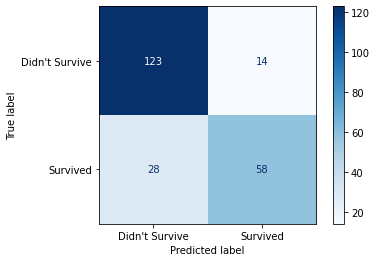

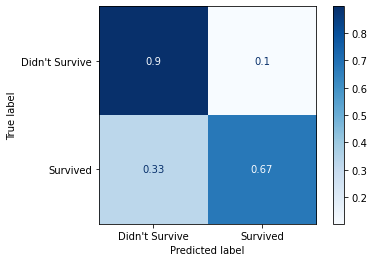

In [22]:
clf_svm = SVC()
clf_svm.fit(X_train_scaled,Y_train)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_svm,X_test_scaled,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

# Support Vector Machine: Optimize parameters with cross validation and GridSearchCV

In [23]:
param_grid = [
    {'C': [0.5,1,10,100],
    'gamma': ['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=10,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(X_train_scaled,Y_train)
print(optimal_params.best_params_)

{&#39;C&#39;: 1, &#39;gamma&#39;: &#39;scale&#39;, &#39;kernel&#39;: &#39;rbf&#39;}


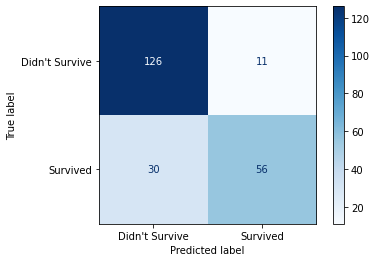

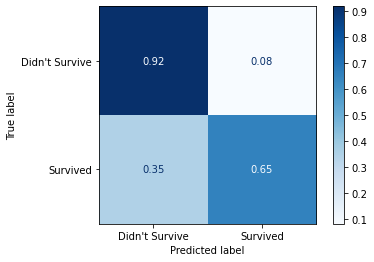

In [24]:
clf_svm = SVC(C=100)
clf_svm.fit(X_train_scaled,Y_train)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_svm,X_test_scaled,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

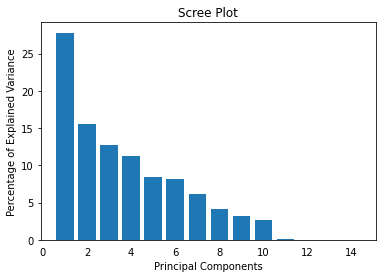

In [25]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = [str(x) for x in range (1,len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [26]:
train_pc1_coords = X_train_pca[:,0]
train_pc2_coords = X_train_pca[:,1]

pca_train_scaled = scale(np.column_stack((train_pc1_coords,train_pc2_coords)))

param_grid = [
    {'C': [0.5,1,10,100],
    'gamma': ['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=10,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(pca_train_scaled,Y_train)
print(optimal_params.best_params_)

{&#39;C&#39;: 100, &#39;gamma&#39;: 1, &#39;kernel&#39;: &#39;rbf&#39;}


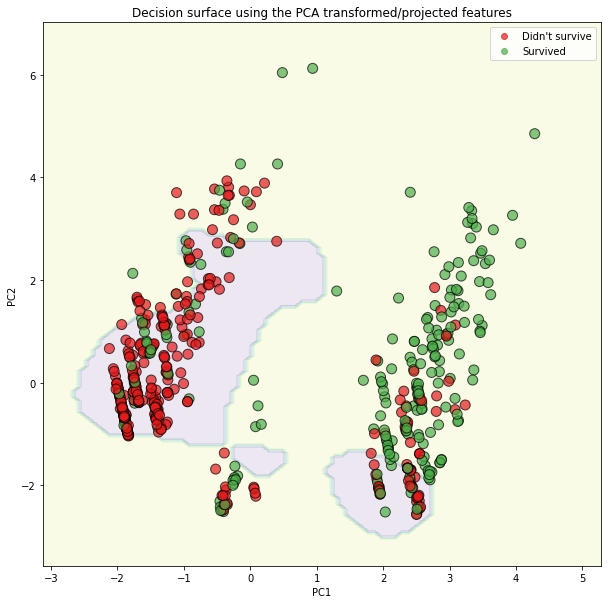

In [27]:
clf_svm = SVC(C=100,gamma=1)
clf_svm.fit(pca_train_scaled,Y_train)

# Transform the test dataset with the PCA
X_test_pca = pca.transform(X_train_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

x_min = test_pc1_coords.min()-1
x_max = test_pc1_coords.max()+1

y_min = test_pc2_coords.min()-1
y_max = test_pc2_coords.max()+1

xx, yy = np.meshgrid(   np.arange(start=x_min, stop=x_max,step=0.1),
                        np.arange(start=y_min, stop=y_max,step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize = (10,10))

ax.contourf(xx,yy,Z,alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c','#4daf4a'])

scatter = ax.scatter(   test_pc1_coords,test_pc2_coords,c=Y_train,
                        cmap = cmap,
                        s=100,
                        edgecolors='k',
                        alpha=0.7)

legend = ax.legend( scatter.legend_elements()[0],
                    scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("Didn't survive")
legend.get_texts()[1].set_text("Survived")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed/projected features')

plt.show()


# Submit Predictions

In [28]:
X_test  = test.drop("PassengerId", axis=1).copy()
X_test_scaled = scale(X_test)

clf_svm = SVC()
clf_svm.fit(X_train_scaled,Y_train)

Y_pred = clf_svm.predict(X_test_scaled)

In [29]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

In [30]:
submission = pd.read_csv('submission.csv')
submission.Survived.mean() # 0.383838 in train

0.3133971291866029

In [31]:
from checkAccuracy import accuracy

0.7833333333333333
